# Наивный Баес

In [6]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
import pandas as pd
from sklearn import datasets as dts
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import random
import timeit

In [7]:
def creat_graph(fpr, tpr, roc_auc, name_dts, n_cls):
    color_graph = ["black", "red", "orange", "yellow", "lime", "cyan", "steelblue"]
    plt.plot(fpr, tpr, color=color_graph[4],
        label= f'ROC кривая (area = {roc_auc:0.3f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-кривая для {name_dts}, класса {n_cls}')
    plt.legend(loc="lower right")
    plt.show()

In [8]:
# Сроим ROC - кривую
def roc(best_rez, x_train, x_test, y_train, y_test, name_dts):
    for j in set(list(y_train) + list(y_test)):
        y_train_class = np.array(y_train)
        y_test_class = np.array(y_test)

        # Ориентируем целевые данные на бинарный рез-тат
        for i in range(len(y_train)):
            y_train_class[i] = 1 if y_train_class[i] == j else 0

        for i in range(len(y_test)):
            y_test_class[i] = 1 if y_test_class[i] == j else 0

        clf = GaussianNB(var_smoothing = best_rez["smoothy"])
        clf.fit(x_train, y_train_class)

        #Строим график
        y_probas = clf.predict_proba(x_test)
        logreg_prob = y_probas[:,1] # берем только положительные исходы

        # рассчитываем roc-кривую
        fpr, tpr, treshold = roc_curve(y_test_class, logreg_prob)
        roc_auc = auc(fpr, tpr)
        creat_graph(fpr, tpr, roc_auc, name_dts, j)

In [9]:
def main():
    for load_dts, name_dts in [(dts.load_iris, "Iris plants dataset"),
                               (dts.load_digits, "Optical recognition of handwritten digits dataset"),
                               (dts.load_wine,"Wine recognition dataset"),
                               (dts.load_breast_cancer, "Breast cancer wisconsin (diagnostic) dataset")]:

        print(name_dts, ":", sep="")

        data = load_dts(); # Загружаем датасеты

        # Разделяем данные
        X = data.data
        y = data.target

        # Нормализация
        min_max_scaler = preprocessing.MinMaxScaler()
        X = min_max_scaler.fit_transform(X)

        # Кроссвалидация
        # Сделаем выбор кроссвалидации под dts
        if name_dts == "Iris plants dataset":

            # RepeatedKFold
            from sklearn.model_selection import RepeatedKFold

            rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42) # n_repeats - кол-во итераций
            classifiers = []

            # метод split возвращает индексы для объектов train и test
            for train_index, test_index in rkf.split(X):
                clf = GaussianNB()
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                clf.fit(X_train, y_train)
                classifiers.append(clf.score(X_test, y_test))
            print("RepeatedKFold: ", classifiers) # Выводим рез-тат кроссвалидации

        elif name_dts == "Optical recognition of handwritten digits dataset":

            # Разобиваем датасет на части в классе (для каждого класса)
            # StratifiedKFold
            from sklearn.model_selection import StratifiedKFold

            skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
            classifiers = []

            # метод split возвращает индексы для объектов train и test
            for train_index, test_index in skf.split(X, y):
                clf = GaussianNB()
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                clf.fit(X_train, y_train)
                classifiers.append(clf.score(X_test, y_test)) # получим 5 оптимальных классификаторов
            print("StratifiedKFold: ", classifiers) # Выводим рез-тат кроссвалидации

        elif name_dts == "Wine recognition dataset":
            # GroupKFold гарантирует, что в тренировочный и тестовый набор не попадут одинаковые группы. Даёт возможность проверить зависимость данных от субъективной оценки наблюдателя.
            from sklearn.model_selection import GroupKFold
            gfd = GroupKFold(n_splits=np.unique(y).size)
            classifiers = []

            # метод split возвращает индексы для объектов train и test
            for train_index, test_index in gfd.split(X, y, groups=[x for x in range(y.size)]):
                clf = GaussianNB()
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                clf.fit(X_train, y_train)
                classifiers.append(clf.score(X_test, y_test)) # получим 5 оптимальных классификаторов
            print("GroupKFold: ", classifiers) # Выводим рез-тат кроссвалидации
        else:
            # ShuffleSplit - рандом
            from sklearn.model_selection import ShuffleSplit
            ss = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
            classifiers = []

            # метод split возвращает индексы для объектов train и test
            for train_index, test_index in ss.split(X):
                clf = GaussianNB()
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                clf.fit(X_train, y_train)
                classifiers.append(clf.score(X_test, y_test)) # получим 5 оптимальных классификаторов
            print("ShuffleSplit: ", classifiers) # Выводим рез-тат кроссвалидации

        # KFold
        from sklearn.model_selection import KFold

        # инициализация KFold с 5тью фолдами
        kf = KFold(n_splits=5, random_state=42, shuffle=True)
        classifiers = []

        # метод split возвращает индексы для объектов train и test
        for train_index, test_index in kf.split(X):
            clf = GaussianNB()
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            clf.fit(X_train, y_train)
            classifiers.append(clf.score(X_test, y_test)) # получим 5 оптимальных классификаторов
        print("KFold: ", classifiers) # Выводим рез-тат кроссвалидации


        # # LeaveOneOut - дорогостоящий не подходит для больших данных
        # from sklearn.model_selection import LeaveOneOut
        # loo = LeaveOneOut()
        # classifiers = []

        # # метод split возвращает индексы для объектов train и test
        # for train_index, test_index in loo.split(X):
        #     clf = GaussianNB()
        #     X_train, X_test = X[train_index], X[test_index]
        #     y_train, y_test = y[train_index], y[test_index]
        #     clf.fit(X_train, y_train)
        #     classifiers.append(clf.score(X_test, y_test)) # получим 5 оптимальных классификаторов
        # print("LeaveOneOut: ", classifiers[:10]) # Выводим рез-тат кроссвалидации

        # # Leave P Out - дорогостоящий не подходит для больших данных
        # from sklearn.model_selection import LeavePOut # ОЧ ДОЛГО ВЫПОЛНЯЕТСЯ
        # lpo = LeavePOut(p = 2)
        # classifiers = []

        # # метод split возвращает индексы для объектов train и test
        # for train_index, test_index in lpo.split(X):
        #     clf = GaussianNB()
        #     X_train, X_test = X[train_index], X[test_index]
        #     y_train, y_test = y[train_index], y[test_index]
        #     clf.fit(X_train, y_train)
        #     classifiers.append(clf.score(X_test, y_test)) # получим 5 оптимальных классификаторов
        # print("LeavePOut: ", classifiers[:10]) # Выводим рез-тат кроссвалидации

        # Деление данных на тестовые и тренировочные
        x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42)

        prior_classes = np.linspace(1, 10, np.unique(y).size) # Создаем массив с приоритетами для классов
        prior_classes = list(prior_classes / np.sum(prior_classes))

        best_rez = {"Bayes": "GaussianNB", "prior_mass": prior_classes, "smoothy": 0, "score": 0} # Сохраняем лучший рез-тат

        # Наивный байес по Гаусу
        for _ in range(len(prior_classes) ** 2): # Подгонка приоритетов классов
            for smoothy in range(10):
            # for j in range(i + 1, len(prior_classes)):
                # prior_classes.size
                # clf = GaussianNB(priors= np.hstack((np.hstack((prior_classes[j:],prior_classes[i:j])), prior_classes[0:i])))
                my_priors = sorted(prior_classes, key=lambda A: random.random())
                if smoothy == 0: # для нулевого значения будем использовать стандартное сглаживание дисперсии
                    clf = GaussianNB(priors = my_priors)
                    smoothy = 1e-9
                else:
                    clf = GaussianNB(priors = my_priors, var_smoothing=smoothy * 0.01)
                    smoothy = smoothy * 0.01
                clf.fit(x_train, y_train)
                my_rezult = clf.score(x_test, y_test)

                if my_rezult > best_rez["score"]: # сохраняем лучший показатель
                    best_rez["Bayes"] = "GaussianNB"
                    best_rez["prior_mass"] = my_priors
                    best_rez["smoothy"] = smoothy
                    best_rez["score"] = my_rezult

        # Мультиноминальный Наивный Байес
        from sklearn.naive_bayes import MultinomialNB
        for f_prior in [True, False]:
            for _ in range(len(prior_classes) ** 2): # Подгонка приоритетов классов
                for smoothy in range(10):
                    my_priors = sorted(prior_classes, key=lambda A: random.random())
                    if smoothy == 0: # для нулевого значения будем использовать стандартное сглаживание дисперсии
                        clf = MultinomialNB(class_prior = my_priors, fit_prior = f_prior)
                        smoothy = 1e-9
                    else:
                        clf = MultinomialNB(class_prior = my_priors, alpha=smoothy * 0.01, fit_prior = f_prior)
                        smoothy = smoothy * 0.01
                    clf.fit(x_train, y_train)
                    my_rezult = clf.score(x_test, y_test)

                    if my_rezult > best_rez["score"]: # сохраняем лучший показатель
                        best_rez["Bayes"] = "MultinomialNB"
                        best_rez["prior_mass"] = my_priors
                        best_rez["smoothy"] = smoothy
                        best_rez["score"] = my_rezult


        # Дополнение наивного Байеса
        from sklearn.naive_bayes import ComplementNB
        for my_norm in [True, False]:
            for f_prior in [True, False]:
                for _ in range(len(prior_classes) ** 2): # Подгонка приоритетов классов
                    for smoothy in range(10):
                        my_priors = sorted(prior_classes, key=lambda A: random.random())
                        if smoothy == 0: # для нулевого значения будем использовать стандартное сглаживание дисперсии
                            clf = ComplementNB(class_prior = my_priors, fit_prior = f_prior, norm = my_norm)
                            smoothy = 1e-9
                        else:
                            clf = ComplementNB(class_prior = my_priors, alpha=smoothy * 0.01, fit_prior = f_prior, norm = my_norm)
                            smoothy = smoothy * 0.01
                        clf.fit(x_train, y_train)
                        my_rezult = clf.score(x_test, y_test)

                        if my_rezult > best_rez["score"]: # сохраняем лучший показатель
                            best_rez["Bayes"] = "ComplementNB"
                            best_rez["prior_mass"] = my_priors
                            best_rez["smoothy"] = smoothy
                            best_rez["score"] = my_rezult

        # Бернулли Наивный Байес
        from sklearn.naive_bayes import BernoulliNB
        for my_binarize in range(0, 11):
            for f_prior in [True, False]:
                for _ in range(len(prior_classes) ** 2): # Подгонка приоритетов классов
                    for smoothy in range(10):
                        my_priors = sorted(prior_classes, key=lambda A: random.random())
                        if smoothy == 0: # для нулевого значения будем использовать стандартное сглаживание дисперсии
                            clf = BernoulliNB(class_prior = my_priors, fit_prior = f_prior, binarize = my_binarize * 0.1)
                            smoothy = 1e-9
                        else:
                            clf = BernoulliNB(class_prior = my_priors, alpha=smoothy * 0.01, fit_prior = f_prior, binarize = my_binarize * 0.1)
                            smoothy = smoothy * 0.01
                        clf.fit(x_train, y_train)
                        my_rezult = clf.score(x_test, y_test)

                        if my_rezult > best_rez["score"]: # сохраняем лучший показатель
                            best_rez["Bayes"] = "BernoulliNB"
                            best_rez["prior_mass"] = my_priors
                            best_rez["smoothy"] = smoothy
                            best_rez["score"] = my_rezult

        # Бернулли Наивный Байес
        from sklearn.naive_bayes import BernoulliNB
        for my_binarize in range(0, 11):
            for f_prior in [True, False]:
                for _ in range(len(prior_classes) ** 2): # Подгонка приоритетов классов
                    for smoothy in range(10):
                        my_priors = sorted(prior_classes, key=lambda A: random.random())
                        if smoothy == 0: # для нулевого значения будем использовать стандартное сглаживание дисперсии
                            clf = BernoulliNB(class_prior = my_priors, fit_prior = f_prior, binarize = my_binarize * 0.1)
                            smoothy = 1e-9
                        else:
                            clf = BernoulliNB(class_prior = my_priors, alpha=smoothy * 0.01, fit_prior = f_prior, binarize = my_binarize * 0.1)
                            smoothy = smoothy * 0.01
                        clf.fit(x_train, y_train)
                        my_rezult = clf.score(x_test, y_test)

                        if my_rezult > best_rez["score"]: # сохраняем лучший показатель
                            best_rez["Bayes"] = "BernoulliNB"
                            best_rez["prior_mass"] = my_priors
                            best_rez["smoothy"] = smoothy
                            best_rez["score"] = my_rezult

        # # Категориальный Наивный Байес
        # from sklearn.naive_bayes import CategoricalNB
        # for my_binarize in range(0, 11):
        #     for f_prior in [True, False]:
        #         for _ in range(len(prior_classes) ** 2): # Подгонка приоритетов классов
        #             for smoothy in range(10):
        #                 my_priors = sorted(prior_classes, key=lambda A: random.random())
        #                 if smoothy == 0: # для нулевого значения будем использовать стандартное сглаживание дисперсии
        #                     clf = CategoricalNB(class_prior = my_priors, fit_prior = f_prior)
        #                     smoothy = 1e-9
        #                 else:
        #                     clf = CategoricalNB(class_prior = my_priors, alpha=smoothy * 0.01, fit_prior = f_prior)
        #                     smoothy = smoothy * 0.01
        #                 clf.fit(x_train, y_train)
        #                 my_rezult = clf.score(x_test, y_test)

        #                 if my_rezult > best_rez["score"]: # сохраняем лучший показатель
        #                     best_rez["Bayes"] = "CategoricalNB"
        #                     best_rez["prior_mass"] = my_priors
        #                     best_rez["smoothy"] = smoothy
        #                     best_rez["score"] = my_rezult

        print(name_dts, "Best score", *[f"{k}: {v};" for k, v in best_rez.items()]) # вывод рез-та
        roc(best_rez, x_train, x_test, y_train, y_test, name_dts) # расчет roc-кривой
        print()



Iris plants dataset:
RepeatedKFold:  [1.0, 0.9666666666666667, 0.9333333333333333, 0.9666666666666667, 0.9333333333333333, 0.9666666666666667, 1.0, 0.8666666666666667, 1.0, 0.9333333333333333]
KFold:  [1.0, 0.9666666666666667, 0.9333333333333333, 0.9666666666666667, 0.9333333333333333]
Iris plants dataset Best score Bayes: GaussianNB; prior_mass: [0.6060606060606061, 0.3333333333333333, 0.06060606060606061]; smoothy: 0.02; score: 1.0;


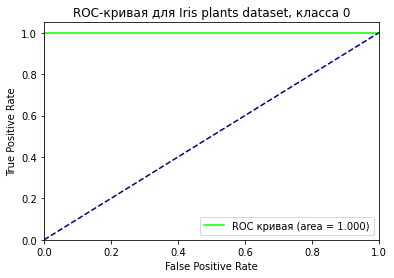

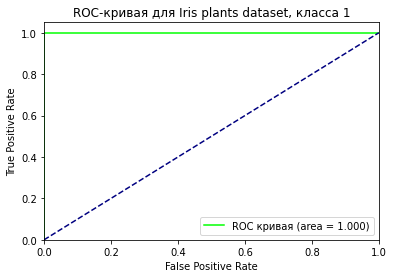

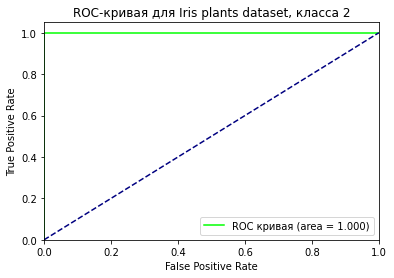


Optical recognition of handwritten digits dataset:
StratifiedKFold:  [0.7916666666666666, 0.8388888888888889, 0.8105849582172702, 0.8050139275766016, 0.8495821727019499]
KFold:  [0.8333333333333334, 0.8138888888888889, 0.7771587743732591, 0.8495821727019499, 0.8217270194986073]
Optical recognition of handwritten digits dataset Best score Bayes: GaussianNB; prior_mass: [0.09090909090909091, 0.03636363636363636, 0.05454545454545454, 0.01818181818181818, 0.16363636363636364, 0.18181818181818182, 0.14545454545454545, 0.07272727272727272, 0.12727272727272726, 0.10909090909090909]; smoothy: 0.08; score: 0.9203703703703704;


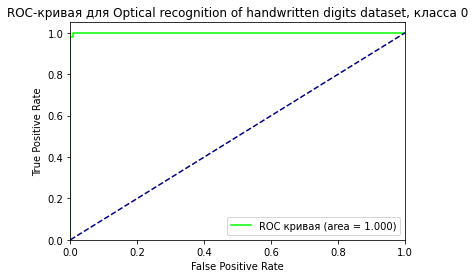

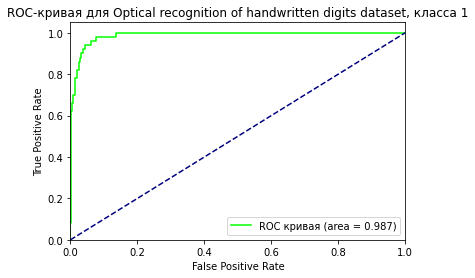

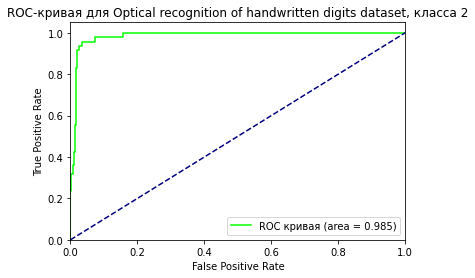

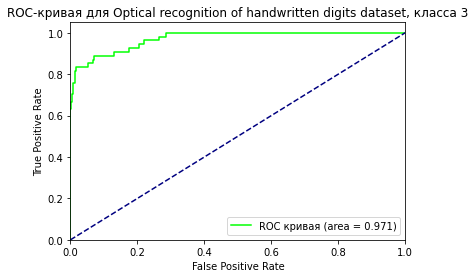

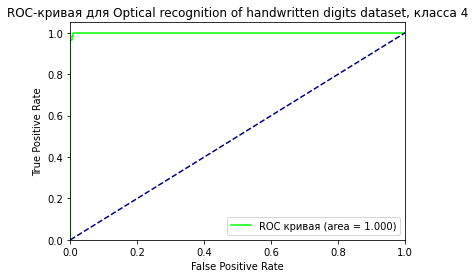

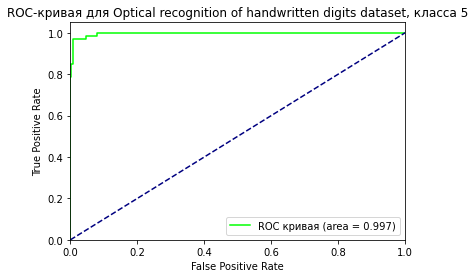

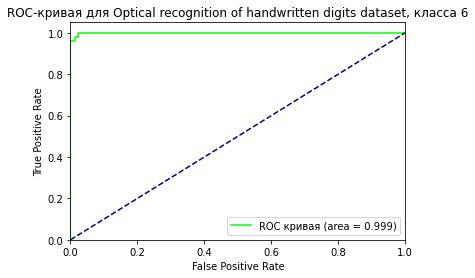

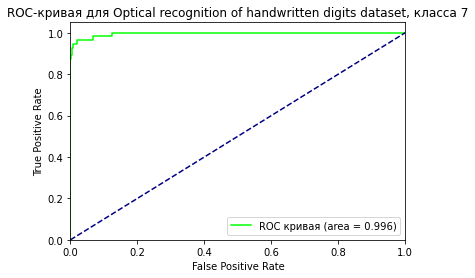

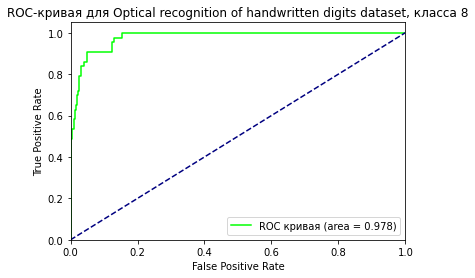

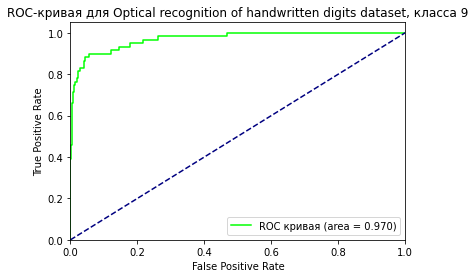


Wine recognition dataset:
GroupKFold:  [1.0, 0.9830508474576272, 0.9322033898305084]
KFold:  [1.0, 1.0, 0.9722222222222222, 0.9428571428571428, 1.0]
Wine recognition dataset Best score Bayes: GaussianNB; prior_mass: [0.06060606060606061, 0.3333333333333333, 0.6060606060606061]; smoothy: 0.01; score: 1.0;


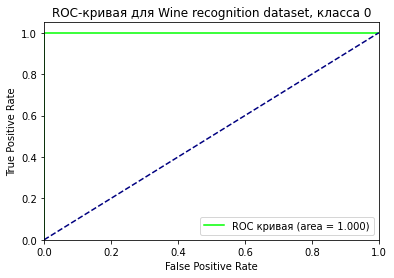

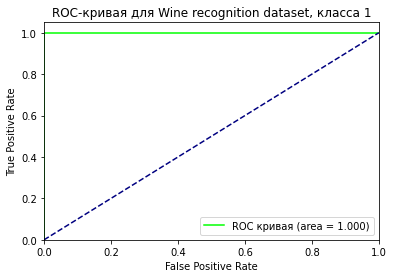

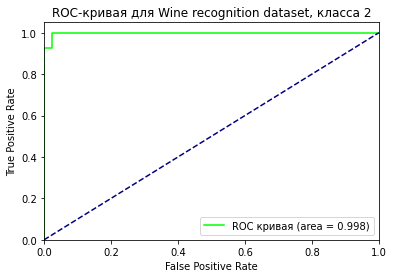


Breast cancer wisconsin (diagnostic) dataset:
ShuffleSplit:  [0.935672514619883, 0.9181286549707602, 0.9590643274853801, 0.9473684210526315, 0.9473684210526315]
KFold:  [0.9649122807017544, 0.9210526315789473, 0.9385964912280702, 0.9298245614035088, 0.9292035398230089]
Breast cancer wisconsin (diagnostic) dataset Best score Bayes: BernoulliNB; prior_mass: [0.09090909090909091, 0.9090909090909091]; smoothy: 1e-09; score: 0.9532163742690059;


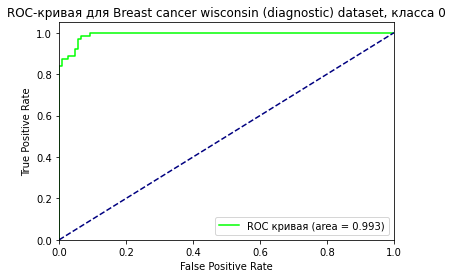

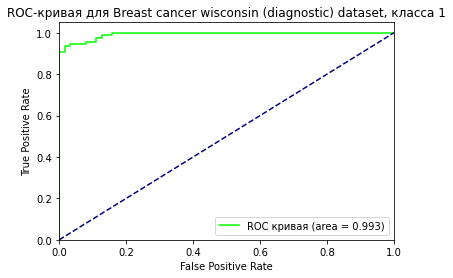

In [10]:
if __name__ == "__main__":
    main()